# Compare basic and meta teacher

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tensordict import TensorDict

from lift.environments.gym_envs import NpGymEnv
from lift.environments.teacher_envs import TeacherEnv, ConditionedTeacher
from lift.environments.rollout import rollout

from lift.teacher import load_teacher
from configs import BaseConfig

In [2]:
config = BaseConfig()

meta_teacher = load_teacher(config, meta=True)
conditioned_teacher = ConditionedTeacher(
    meta_teacher,
    alpha_apply_range=[0., 3.])
conditioned_teacher.reset()

basic_teacher = load_teacher(config, meta=False)


MetaSAC teacher loaded

SAC teacher loaded


In [3]:
def eval_teacher_rollout(
    teacher, 
    env_noise, 
    env_noise_slope, 
    teacher_noise, 
    teacher_noise_slope, 
    n_steps=3000,
):
    env = NpGymEnv("FetchReachDense-v2", max_episode_steps=100)
    env = TeacherEnv(
        env, 
        noise_range=[env_noise, env_noise], 
        noise_slope_range=[env_noise_slope, env_noise_slope], 
        append_obs=False,
    )

    data = rollout(
        env,
        teacher,
        n_steps=n_steps,
        terminate_on_done=False,
        reset_on_done=True,
        random_pertube_prob=0.,
        action_noise=0.,
    )

    data['env_noise'] = env_noise
    data['env_noise_slope'] = env_noise_slope

    return data

In [4]:
def compute_mae_std(data):
    with torch.no_grad():
        dist = conditioned_teacher.get_action_dist(data['obs'])
        meta_actions = dist.sample()
    abs_err = np.abs(data['act'] - meta_actions.numpy())
    return abs_err.mean(), dist.scale.mean().item()

def compute_kl(data):
    o = torch.tensor(data['obs']['observation'], dtype=torch.float32)
    z = torch.tensor(data['act'], dtype=torch.float32)

    basic_inputs = TensorDict({
        "observation": o,
        "action": z,
    })

    with torch.no_grad():
        log_prior = conditioned_teacher.get_action_dist(data['obs']).log_prob(z)
        z_dist = basic_teacher.model.policy.get_dist(basic_inputs)
    ent = -z_dist.log_prob(z)
    kl = -(log_prior + ent).mean()
    return kl

In [6]:
np.random.seed(0)

def evaluate_rollout(eval_rollout, alpha):
    num_rows = 8
    num_cols = 8
    teacher_noises = np.linspace(0., 1., num=num_rows)
    teacher_noise_slopes = np.linspace(0., 1., num=num_cols)

    results = {
        'kl' : np.zeros((num_rows, num_cols)),
        'mae': np.zeros((num_rows, num_cols)),
        'scale': np.zeros((num_rows, num_cols)),
    }

    for i, teacher_noise in enumerate(teacher_noises):
        for j, teacher_noise_slope in enumerate(teacher_noise_slopes):
            # update conditioned teacher
            meta_vars = {
                'noise': teacher_noise,
                'noise_slope': teacher_noise_slope,
                'alpha': alpha,
            }
            conditioned_teacher.set_meta_vars(meta_vars)

            eval_rollout['teacher_noise'] = torch.tensor(teacher_noise)
            eval_rollout['teacher_noise_slope'] = torch.tensor(teacher_noise_slope)
            results['mae'][i,j], results['scale'][i,j] = compute_mae_std(eval_rollout)
            results['kl'][i,j] = compute_kl(eval_rollout)

    return results, teacher_noises, teacher_noise_slopes

In [7]:
# eval teacher with different meta variables in the same environment
env_noise = 0.
env_noise_slope = 0.

teacher_noise = None
teacher_noise_slope = None

eval_rollout_1 = eval_teacher_rollout(
    basic_teacher,
    env_noise, 
    env_noise_slope,
    teacher_noise,
    teacher_noise_slope,
)

alpha = 1
results_1, teacher_noises, teacher_noise_slopes = evaluate_rollout(eval_rollout_1, alpha)

Rollout: 100%|██████████| 3000/3000 [00:03<00:00, 763.61item/s]


In [8]:
env_noise = 1.
env_noise_slope = 1.

teacher_noise = None
teacher_noise_slope = None

eval_rollout_2 = eval_teacher_rollout(
    basic_teacher,
    env_noise, 
    env_noise_slope,
    teacher_noise,
    teacher_noise_slope,
)

alpha = 1
results_2, teacher_noises, teacher_noise_slopes = evaluate_rollout(eval_rollout_2, alpha)

Rollout: 100%|██████████| 3000/3000 [00:03<00:00, 799.27item/s]


In [9]:
alpha = 3
results_3, teacher_noises, teacher_noise_slopes = evaluate_rollout(eval_rollout_1, alpha)
results_4, teacher_noises, teacher_noise_slopes = evaluate_rollout(eval_rollout_2, alpha)

In [10]:
def plot_heat_map(eval_stats, ax, xlabel, ylabel):
    df = pd.DataFrame(
        eval_stats, 
        index=[round(i, 2) for i in teacher_noises.tolist()], 
        columns=[round(i, 2) for i in teacher_noise_slopes.tolist()], 
    )
    sns.heatmap(df, annot=True, cbar=False, fmt=".2f", cmap="Blues", ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

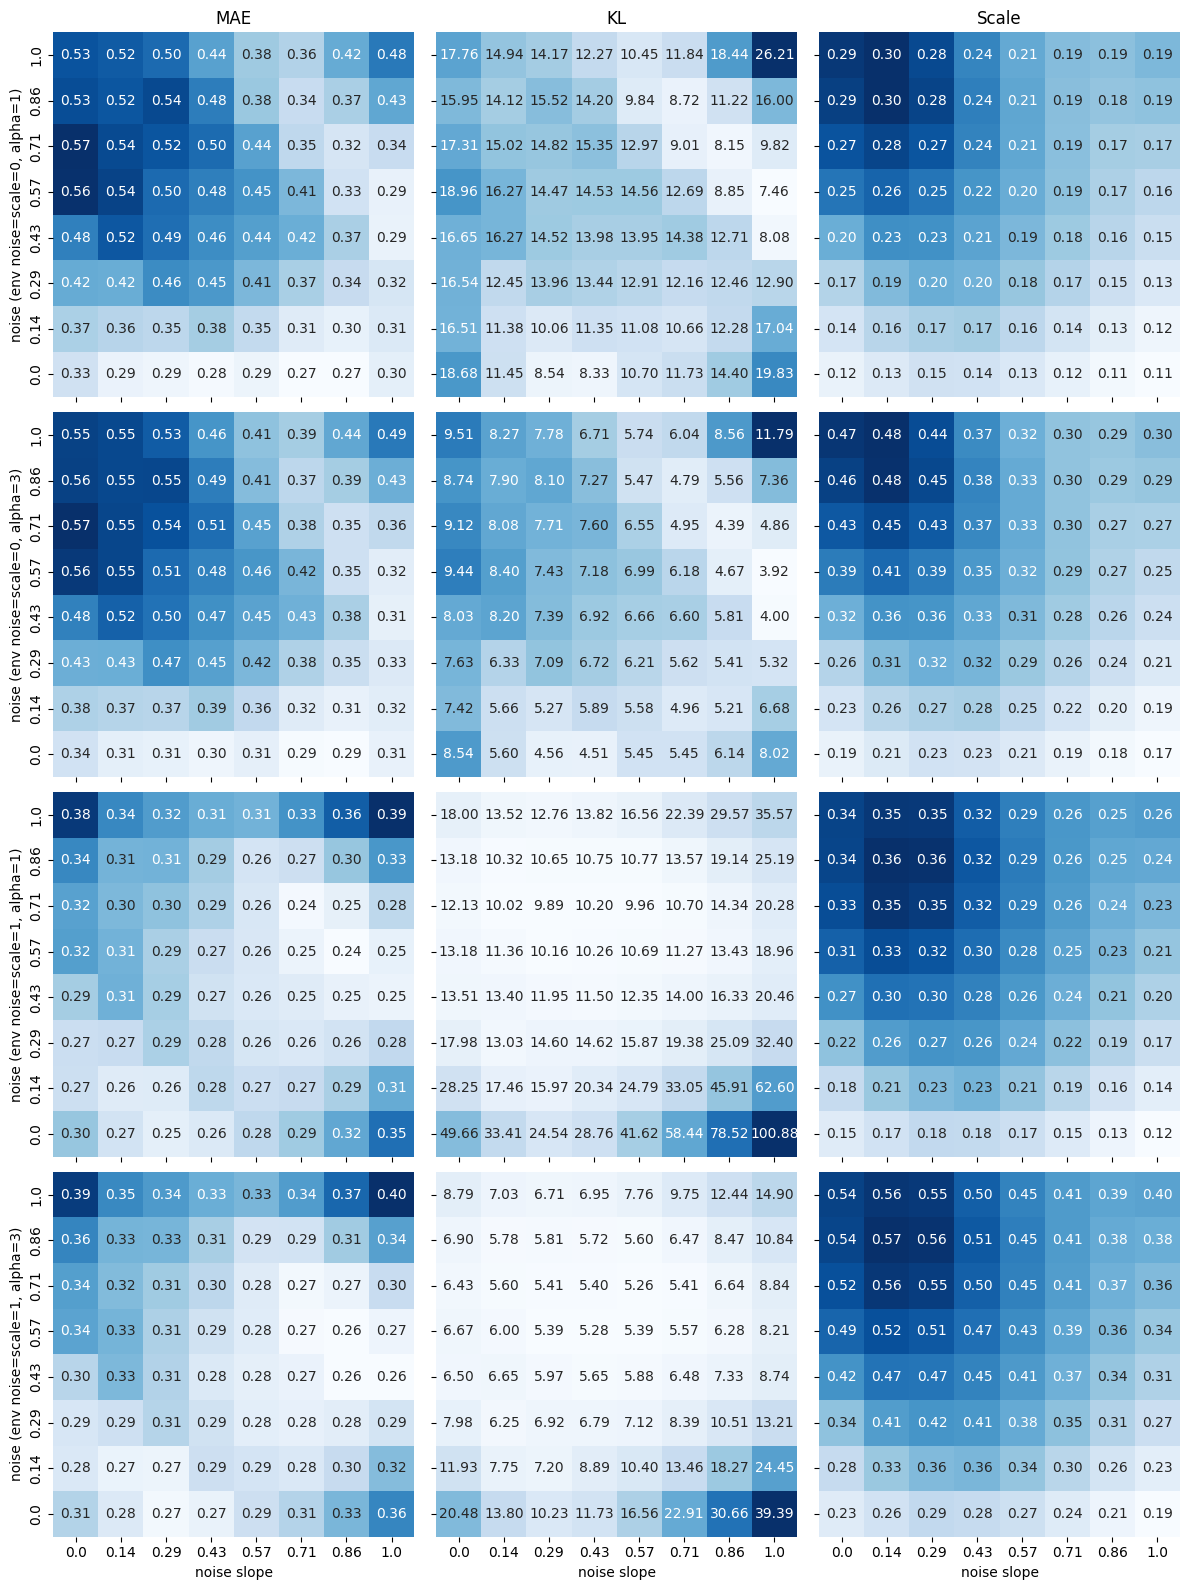

In [11]:
fig, ax = plt.subplots(4, 3, figsize=(12, 16), sharex=True, sharey=True)
plot_heat_map(results_1['mae'], ax[0,0], "", "noise (env noise=scale=0, alpha=1)")
plot_heat_map(results_1['kl'], ax[0,1], "", "")
plot_heat_map(results_1['scale'], ax[0,2], "", "")
plot_heat_map(results_2['mae'], ax[2,0], "", "noise (env noise=scale=1, alpha=1)")
plot_heat_map(results_2['kl'], ax[2,1], "", "")
plot_heat_map(results_2['scale'], ax[2,2], "", "")
plot_heat_map(results_3['mae'], ax[1,0], "", "noise (env noise=scale=0, alpha=3)")
plot_heat_map(results_3['kl'], ax[1,1], "", "")
plot_heat_map(results_3['scale'], ax[1,2], "", "")
plot_heat_map(results_4['mae'], ax[3,0], "noise slope", "noise (env noise=scale=1, alpha=3)")
plot_heat_map(results_4['kl'], ax[3,1], "noise slope", "")
plot_heat_map(results_4['scale'], ax[3,2], "noise slope", "")

ax[0,0].set_title("MAE")
ax[0,1].set_title("KL")
ax[0,2].set_title("Scale")
plt.tight_layout()